<center><img src="https://i.imgur.com/FHMoW3N.png" width=360px><br><b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Collaborative training <sup>v0.9 alpha</sup></b></center>


This notebook will use local or colab GPU to help train ALBERT-large collaboratively. Your instance will compute gradients and exchange them with a bunch of volunteers around the world. We explain how it works at the bottom. But for now, please run all cells :)

This is a test run to check if we have fixed the hanging issues from __v11__, found and reported by YSDA students. The run will be terminated by __23:59 28 april GMT+0__. Please run at most one kaggle and one colab kernel concurrently in order to comply with their EULA.

__BEFORE YOU RUN:__ please ensure that both GPU and internet access are enabled in a menu on the right:

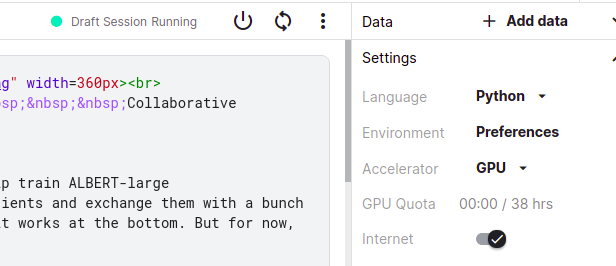


In [ ]:
!pip install transformers datasets sentencepiece torch_optimizer==0.1.0
!git clone https://github.com/learning-at-home/hivemind -b averager_qual2
!cd hivemind && pip install -e .
!curl -L https://hivemind-data.s3.us-east-2.amazonaws.com/wikitext103.tar.gz | tar xzf -

import torch
assert torch.cuda.is_available(), "GPU device not found. Make sure you enabled GPU (see menu on the right)."
device_name = torch.cuda.get_device_name(0)
microbatch_size = 4 if 'T4' in device_name or 'P100' in device_name else 1
print(f"Running with device {device_name}, local batch size = {microbatch_size}")

!ulimit -n 4096 && HIVEMIND_THREADS=256 python ./hivemind/examples/albert/run_trainer.py \
 --client_mode --initial_peers 18.224.82.24:31337 --averaging_expiration 10 --statistics_expiration 120 \
 --batch_size_lead 200 --per_device_train_batch_size {microbatch_size} --gradient_accumulation_steps 1 \
 --logging_first_step --logging_steps 100  --output_dir ./outputs --overwrite_output_dir --logging_dir ./logs \
 --experiment_prefix albert-wikitext-v11 --seed 42

### What's up next?
* Check the training progress on public learning curves: https://wandb.ai/yhn112/Demo-run/runs/3mfdz8aw
* See [this tutorial](https://github.com/learning-at-home/hivemind/tree/master/examples/albert) on how to start your own collaborative runs!

_Co-created by [leshanbog](https://github.com/leshanbog), [yhn112](https://github.com/yhn112) and [foksly](https://github.com/foksly) from [hivemind](https://github.com/learning-at-home/hivemind) (YSDA), [lhoestq](https://github.com/lhoestq), [SaulLu](https://github.com/SaulLu) and [stas00@](https://github.com/stas00) from [huggingface](http://huggingface.co)_.



### How it works

Since peers can join and leave at any time, we can't use global [Ring All-Reduce](https://towardsdatascience.com/visual-intuition-on-ring-allreduce-for-distributed-deep-learning-d1f34b4911da) for averaging: a single missing peer can break the entire protocol. Instead, peers dynamically assemble into small groups and run all-reduce within each group. Consider an example with 9 GPUs:

<center>
<img src="https://i.imgur.com/QcD1mfG.png" width=360px><br>
The All-Reduce protocol within group can be Ring-AllReduce, but we use a simpler all-to-all algorithm known as butterfly-like all-reduce.<br>
<img src="https://i.imgur.com/ewq3vS6.png" width=380px><br>
After each successful round, participants shuffle around and find new groups:<br>
<img src="https://i.imgur.com/dexNCL3.png" width=350px>

If one of the peers fails to do his part, it will only affect his local group, and only for a single round.


<img src="https://i.imgur.com/RBmElUi.png" width=340px>

Afterwards, peers from the failed group will find new groupmates according to the [moshpit algorithm](https://arxiv.org/abs/2103.03239).

</center>


If you want to learn more and even host your own collaborative experiments, take a look at the [hivemind library](https://github.com/learning-at-home/hivemind/) or the [Moshpit-SGD paper](https://arxiv.org/pdf/2103.03239.pdf).